## Section 1: Preprocessing 

In this section, we will preprocess our dataset which consists of three main steps. In the first step, we will revise some features such as dates by splitting into seperate columns (Month, Day, Year) and turning string values for time (ex. 1 yr 1 mon) to a numerical values, representing months (i.e. 13). In the next step, we will convert our categorical values into dummy variables. Lastly, we will look standardize our numerical features. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from datetime import datetime

Import our data file that was saved from our Data Wrangling edits: 'Vehicle_Loan_DataWrang.csv': 'VL_df'

In [2]:
VL_df = pd.read_csv(f'./data/Vehicle_Loan_DataWrang.csv')
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      233154 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

The features 'Date.of.Birth' and 'DisbursalDate' are dates. We will store the year, month and day of each of those features as seperate columns. We will turn them into datetime objects and create those new features. 

In [3]:
# Turn these date features into datetime objects.
VL_df['Date.of.Birth'] = VL_df['Date.of.Birth'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
VL_df['DisbursalDate'] = VL_df['DisbursalDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [4]:
# Create separate year, month and day features for the feature 'Date.of.Birth'
VL_df['birth_year'] = VL_df['Date.of.Birth'].dt.year
VL_df['birth_month'] = VL_df['Date.of.Birth'].dt.month
VL_df['birth_day'] = VL_df['Date.of.Birth'].dt.day

# Create separate year, month and day features for the feature 'DisbursalDate'
VL_df['Disbursal_year'] = VL_df['DisbursalDate'].dt.year
VL_df['Disbursal_month'] = VL_df['DisbursalDate'].dt.month
VL_df['Disbursal_day'] = VL_df['DisbursalDate'].dt.day

In [5]:
# Take a look at the dateframe to see that the date components were extracted correctly.
VL_df[['Date.of.Birth', 'birth_year','birth_month', 'birth_day', 
       'DisbursalDate', 'Disbursal_year','Disbursal_month', 'Disbursal_day']]

,Date.of.Birth,birth_year,birth_month,birth_day,DisbursalDate,Disbursal_year,Disbursal_month,Disbursal_day
0,1984-01-01,1984,1,1,2018-08-03,2018,8,3
1,1985-07-31,1985,7,31,2018-09-26,2018,9,26
2,1985-08-24,1985,8,24,2018-08-01,2018,8,1
3,1993-12-30,1993,12,30,2018-10-26,2018,10,26
4,1977-12-09,1977,12,9,2018-09-26,2018,9,26
...,...,...,...,...,...,...,...,...
233149,1988-08-01,1988,8,1,2018-10-26,2018,10,26
233150,1988-12-05,1988,12,5,2018-10-23,2018,10,23
233151,1976-06-01,1976,6,1,2018-10-24,2018,10,24
233152,1994-03-26,1994,3,26,2018-09-29,2018,9,29


In [6]:
# Remove the original 'Date.of.Birth' and 'DisbursalDate' features as we have those new 
# features. Those new features will be much more useful for the model.

VL_df = VL_df.drop(['Date.of.Birth', 'DisbursalDate'], axis=1)
VL_df.info()    # Output to see that those two features are gone and replaced with new ones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  object 
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

The 'AVERAGE.ACCT.AGE' and 'CREDIT.HISTORY.LENGTH' features represent age or length of given account or credit. The values are stored as strings in a format such as '1yrs 11mon' 
representing 1 year and 11 months or 23 months. We want to convert these values to numerical months. 

In [7]:
# The first two lines remove the 'yrs' and 'mon' portion of the strings and save them 
# in a new dataframe column VL_df['AVG.ACCT.AGE']. The last line will turn it into the age
# in numerical months.
VL_df['AVG.ACCT.AGE'] = VL_df['AVERAGE.ACCT.AGE'].apply(lambda x: x.replace('mon',''))
VL_df['AVG.ACCT.AGE'] = VL_df['AVG.ACCT.AGE'].apply(lambda x: x.replace('yrs',''))
VL_df['AVG.ACCT.AGE'] = VL_df['AVG.ACCT.AGE'].apply(lambda x: 12*int(x[:x.find(' ')+1]) + int(x[x.find(' '):]))

# Similar as above but for credit history length.
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.replace('mon',''))
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CRT.HISTORY.LENGTH'].apply(lambda x: x.replace('yrs',''))
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CRT.HISTORY.LENGTH'].apply(lambda x: 12*int(x[:x.find(' ')+1]) + int(x[x.find(' '):]))

In [8]:
# Verify that the new feature values were computed correctly.
VL_df[['AVERAGE.ACCT.AGE', 'AVG.ACCT.AGE','CREDIT.HISTORY.LENGTH','CRT.HISTORY.LENGTH']]

,AVERAGE.ACCT.AGE,AVG.ACCT.AGE,CREDIT.HISTORY.LENGTH,CRT.HISTORY.LENGTH
0,0yrs 0mon,0,0yrs 0mon,0
1,1yrs 11mon,23,1yrs 11mon,23
2,0yrs 0mon,0,0yrs 0mon,0
3,0yrs 8mon,8,1yrs 3mon,15
4,0yrs 0mon,0,0yrs 0mon,0
...,...,...,...,...
233149,1yrs 9mon,21,3yrs 3mon,39
233150,0yrs 6mon,6,0yrs 6mon,6
233151,0yrs 0mon,0,0yrs 0mon,0
233152,0yrs 0mon,0,0yrs 0mon,0


In [9]:
# Drop the original columns.
VL_df = VL_df.drop(['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], axis=1)
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  object 
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

In [10]:
## We update our categorial columns list from the Exploratory Analysis section with 
## our new features.
categorical_cols = ['UniqueID', 'branch_id', 'supplier_id', 'manufacturer_id', 
                   'Current_pincode_ID', 'Employment.Type', 
                   'State_ID', 'Employee_code_ID', 
                   'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 
                   'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE.DESCRIPTION',
                   'birth_year','birth_month','birth_day', 'Disbursal_year',
                   'Disbursal_month','Disbursal_day','AVG.ACCT.AGE', 'CRT.HISTORY.LENGTH']

In [11]:
## Check to see that they are categorical
VL_df[categorical_cols].head()

,UniqueID,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,...,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION,birth_year,birth_month,birth_day,Disbursal_year,Disbursal_month,Disbursal_day,AVG.ACCT.AGE,CRT.HISTORY.LENGTH
0,420825,67,22807,45,1441,Salaried,6,1998,1,1,...,0,No Bureau History Available,1984,1,1,2018,8,3,0,0
1,537409,67,22807,45,1502,Self employed,6,1998,1,1,...,0,I-Medium Risk,1985,7,31,2018,9,26,23,23
2,417566,67,22807,45,1497,Self employed,6,1998,1,1,...,0,No Bureau History Available,1985,8,24,2018,8,1,0,0
3,624493,67,22807,45,1501,Self employed,6,1998,1,1,...,0,L-Very High Risk,1993,12,30,2018,10,26,8,15
4,539055,67,22807,45,1495,Self employed,6,1998,1,1,...,0,No Bureau History Available,1977,12,9,2018,9,26,0,0


In [12]:
## We want number of unique values for each categorical variable.
for column in categorical_cols:
    print(len(VL_df[column].unique()),'unique values for', column)

233154 unique values for UniqueID
82 unique values for branch_id
2953 unique values for supplier_id
11 unique values for manufacturer_id
6698 unique values for Current_pincode_ID
3 unique values for Employment.Type
22 unique values for State_ID
3270 unique values for Employee_code_ID
1 unique values for MobileNo_Avl_Flag
2 unique values for Aadhar_flag
2 unique values for PAN_flag
2 unique values for VoterID_flag
2 unique values for Driving_flag
2 unique values for Passport_flag
20 unique values for PERFORM_CNS.SCORE.DESCRIPTION
48 unique values for birth_year
12 unique values for birth_month
31 unique values for birth_day
1 unique values for Disbursal_year
3 unique values for Disbursal_month
31 unique values for Disbursal_day
192 unique values for AVG.ACCT.AGE
294 unique values for CRT.HISTORY.LENGTH


In [13]:
VL_df['Employment.Type'].unique()

array(['Salaried', 'Self employed', 'Other'], dtype=object)

In [14]:
# Create numerical values for Employee.Type
replace_map = {'Employment.Type': {'Other': 1, 'Salaried': 2,'Self employed': 3}}
VL_df = VL_df.replace(replace_map)

In [15]:
# Check the count for each value in 'PERFORM_CNS.SCORE.DESCRIPTION'
VL_df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

In [16]:
replace_map = {'PERFORM_CNS.SCORE.DESCRIPTION':{'Not Scored: More than 50 active Accounts found' : 0, 
                                               'Not Scored: Only a Guarantor':0,
                                               'Not Scored: No Updates available in last 36 months':0,
                                               'Not Scored: No Activity seen on the customer (Inactive)':0,
                                               'Not Scored: Not Enough Info available on the customer':0,
                                               'Not Scored: Sufficient History Not Available':0,
                                               'No Bureau History Available':0, 'C-Very Low Risk':1,
                                               'A-Very Low Risk':1, 'D-Very Low Risk':1, 'B-Very Low Risk':1,
                                               'M-Very High Risk':1, 'F-Low Risk':2, 'E-Low Risk':2, 
                                               'G-Low Risk':2, 'H-Medium Risk':3, 'I-Medium Risk':3,
                                               'K-High Risk':4, 'J-High Risk':4, 'M-Very High Risk':5,
                                               'L-Very High Risk':5}}

VL_df = VL_df.replace(replace_map)
VL_df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

0    129785
1     50728
2     18294
3     12412
4     12025
5      9910
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [17]:
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  int64  
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

Let's create dummy variables for these. We will not make dummy variables for UniqueID and MobileNo_Avl_Flag. UniqueID can act as our index or the unique loan. MobileNo_Avl_Flag has only one value. We can probably even omit it later on.

In [18]:
# List of categorical variables to convert to dummies
# dummies = ['branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 
#              'Employee_code_ID', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
#             'Passport_flag', 'birth_year', 'birth_month', 'birth_day', 'Disbursal_year',
#             'Disbursal_month', 'Disbursal_day', 'AVG.ACCT.AGE', 'CRT.HISTORY.LENGTH']

# List of prefixes for each new dummy variable column
# prefix = ['Branch_','Supp_', 'Manufact_', 'CurrPIN_ID_', 'state_', 'employee_', 'AadharFlag_',
#            'PANFlag_', 'VoterID_Flag_', 'DrivingFlag_', 'PassportFlag_', 'birthYR_', 
#            'birthMN_', 'birthDY_', 'DisbursalYR_', 'DisbursalMN', 'DisbursalDY_', 'Avg.ACCT.Age_',
#            'Crdt.Hist.Length_']

# revised_dummies = []

# Add converted dummy dataframes into list: revised_dummies
# for i in range(len(dummies)):
#     revised_dummies.append(pd.get_dummies(VL_df[dummies[i]], prefix=prefix[i]) )

In [19]:
### These categorical variables don't require prefixes when converted to dummies. Hence
### they are converted uniquely.

# Since employment types are given as strings not numbers, we will not specify a prefix.
# dummies_employment = pd.get_dummies(VL_df['Employment.Type'])
# Want to specify other as other employment
# dummies_employment.rename(columns = {'Other':'Other Employment'}, inplace=True) 
# revised_dummies.append(dummies_employment)  # append to revised_dummies list

# Since PERFORM_CNS.SCORE.DESCRIPTION is given as strings not numbers, we will not specify a prefix.
# dummies_PERFORM_CNS = pd.get_dummies(VL_df['PERFORM_CNS.SCORE.DESCRIPTION'])
# revised_dummies.append(dummies_PERFORM_CNS)  # append to revised_dummies list

In [20]:
### Concat dummy dataframes in the list to one large dataframe: revised_dummies_df
# revised_dummies_df = pd.concat(revised_dummies, axis = 1)

In [21]:
### Concat the original dataframe Vl_df to our revised_dummies_df
# VL_df_revised = pd.concat([VL_df, revised_dummies_df], axis=1)

In [22]:
### Drop the original categorical variables.
# VL_df_revised = VL_df_revised.drop(['branch_id','supplier_id', 'manufacturer_id', 
#                    'Current_pincode_ID', 'Employment.Type', 
#                    'State_ID', 'Employee_code_ID', 
#                    'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 
#                    'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE.DESCRIPTION',
#                     'birth_year','birth_month','birth_day','Disbursal_year',
#                     'Disbursal_month','Disbursal_day','AVG.ACCT.AGE', 'CRT.HISTORY.LENGTH'], axis = 1)

# VL_df_revised

We will now split the data set into training and test data and then perform standard scalers on the numerical columns.

In [23]:
# !pip install imblearn

In [24]:
# pip install -U imbalanced-learn

In [25]:
# Splitting the training and testing data

# X = VL_df_revised.loc[:, VL_df_revised.columns != 'loan_default' or != 'UniqueID']
X = VL_df.drop(['loan_default', 'UniqueID', 'Current_pincode_ID', 'supplier_id'], axis=1)
y = VL_df['loan_default']   # this is our predictor variable

# Since there is an inbalance in the two classes (0 and 1) we will use SMOTE to resample
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_sample(X, y.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=26)

We will now plot boxplots for numerical features as they are, to see the scale differences. We will then perform normalization as well as standardization on there features and compare the scales by looking at the boxplots. 

Filter out the numerical features: 'ltv','disbursed_amount', 'asset_cost', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',  'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES'

We determined these features as numerical from the Exploratory Analysis section.

In [26]:
## First, save the numerical column names into a list, num_cols.
num_cols = ['ltv','disbursed_amount', 'asset_cost', 'PERFORM_CNS.SCORE', 
                'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 
                'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 
                'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 
                'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
                'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
                'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES']

Use the StandardScaler to standardize each feature around their mean and respective standard deviations. 

In [27]:
# Data standardization
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

for i in X_train.columns:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]]) 

Here we plot boxplots for numerical variables before and after we standardize. We applied a log tranform base e, to make it more readable. You will see that the boxplots after standardization are better scaled.

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1157: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)
/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

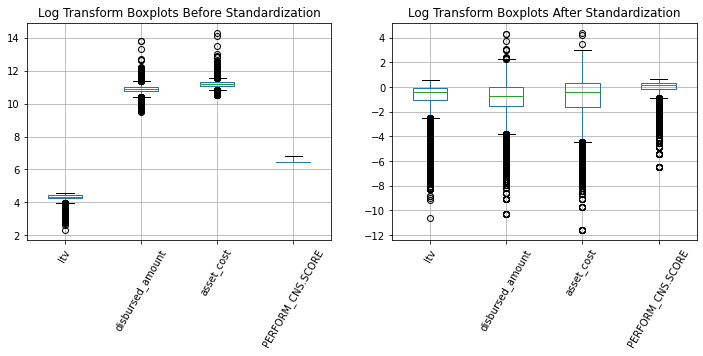

In [28]:
## USE LOG SCALE ON Y axis for both
## Boxplots Before and After Standardization: 'ltv','disbursed_amount', 
## 'asset_cost', and 'PERFORM_CNS.SCORE'
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
ax = np.log(X_train[num_cols[0:4]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots Before Standardization')

plt.subplot(1,2,2)
ax = np.log(X_train_stand[num_cols[0:4]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1157: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Us

Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

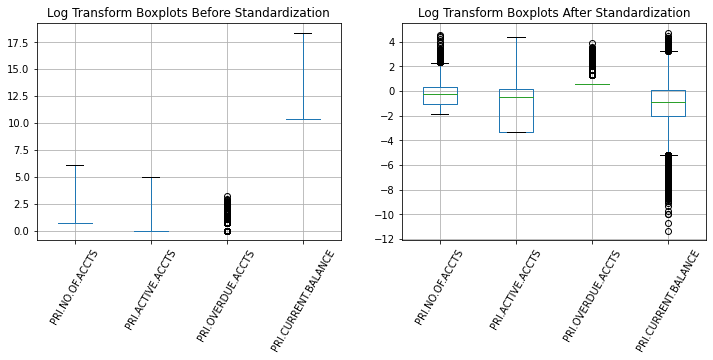

In [29]:
## Boxplots Before and After Standardization: 'PRI.NO.OF.ACCTS', 
## 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', and 'PRI.CURRENT.BALANCE'
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
ax = np.log(X_train[num_cols[4:8]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots Before Standardization')

plt.subplot(1,2,2)
ax = np.log(X_train_stand[num_cols[4:8]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1157: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remo

Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

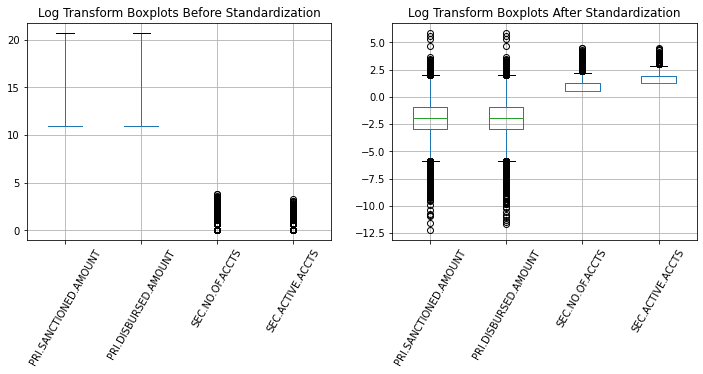

In [30]:
## Boxplots Before and After Standardization: 'PRI.SANCTIONED.AMOUNT', 
## 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', and 'SEC.ACTIVE.ACCTS'
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
ax = np.log(X_train[num_cols[8:12]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots Before Standardization')

plt.subplot(1,2,2)
ax = np.log(X_train_stand[num_cols[8:12]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Us

Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

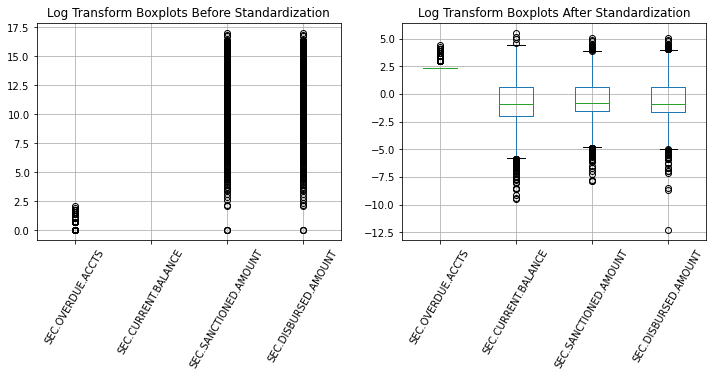

In [31]:
## Boxplots Before and After Standardization: 'SEC.OVERDUE.ACCTS', 
## 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 
## and 'SEC.DISBURSED.AMOUNT'
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
ax = np.log(X_train[num_cols[12:16]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots Before Standardization')

plt.subplot(1,2,2)
ax = np.log(X_train_stand[num_cols[12:16]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1157: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is

Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

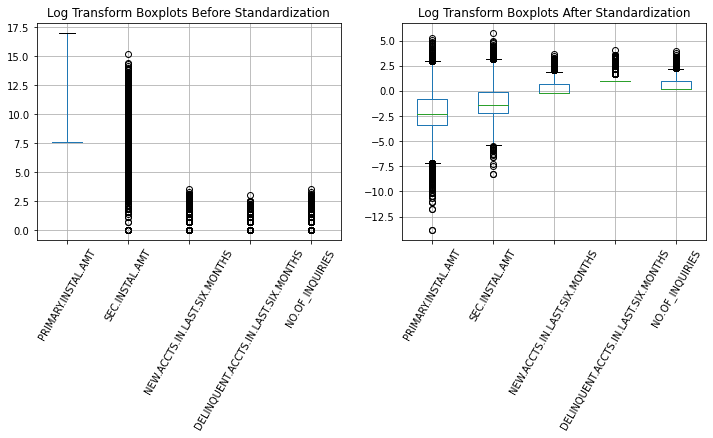

In [32]:
## Boxplots Before and After Standardization: 'PRIMARY.INSTAL.AMT', 
## 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
## 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', and 'NO.OF_INQUIRIES'
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
ax = np.log(X_train[num_cols[16:21]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots Before Standardization')

plt.subplot(1,2,2)
ax = np.log(X_train_stand[num_cols[16:21]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

If we look at the statistics for the numerical features for X_train and X_train_stand (where X_train_stand is after the features are standardized), we see that the values are standardized around the mean for the features so we've scaled accordingly. 

Save the preprocessed dataframe into directory is case we want to see the dataset in a csv format.

In [35]:
### Save dataframe as a CSV for future use with non-standardized data. 
import os
path="/Users/student/Desktop/SpringBoardDSCareerTrack/Capstone 2 Datasets/Vehicle Loan Payments"
os.chdir(path)
VL_df.to_csv('VLData_Preprocessed.csv') 

## Section 2: Modeling

In this section, we will use the training and test data from section 1 to build our three models. We will use the standardized trainings sets as inputs for the Decision Tree model and analyze the performance. Then, we will utilize ensemble methods such as Random Forest and Gradient Boosting. 

We did not use logistic regression and K-nearest neighbor due to slow runtime for a dataset of this size. 

## Model 1: Decision Tree

Import the necessary packages.

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
import sklearn.metrics

Instantiate and build decision tree model.

In [37]:
from sklearn import tree, metrics

# Build intitial decision tree model. We will use Grid Search CV after.
decision_tree = tree.DecisionTreeClassifier(random_state=1234)
decision_tree.fit(X_train_stand, y_train)
y_pred = decision_tree.predict(X_test_stand)
pd.Series(y_pred)
decision_tree

DecisionTreeClassifier(random_state=1234)

Next, perform cross validation with the parameters given in param_dict. Obtain the best params for our decision tree model.

In [38]:
# param_dict will be passed into grid search cross validation
param_dict = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1,10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}

# Perform GridSearchCV=
grid = GridSearchCV(decision_tree, param_grid=param_dict, cv=5,verbose=1,n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/student/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413
 0.57050413 0.57050413 0.57050413        nan 0.57050413 0.57050413
 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413
        nan 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413
 0.57050413 0.57050413 0.57050413        nan 0.57050413 0.57050413
 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413 0.57050413
        nan 0.614511   0.614511   0.614511   0.614511   0.614511
 0.614511   0.614511   0.614511          nan 0.614511   0.614511
 0.614511   0.614511   0.614511   0.614511   0.614511   0.614511
        nan 0.614511   0.614511   0.614511   0.614511   0.614511
 0.614511   0.614511   0.614511          nan 0.614511   0.614511
 0.614511   0.614511   0.614511   0.614511   0.614511   0.614511
        nan 0.6454627  0.6454627  0.6454627  0.6454

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [40]:
print('The best parameters are ',grid.best_params_)
print('The respective estimator is ', grid.best_estimator_)
print('The corresponding best score is ',grid.best_score_)

The best parameters are  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7}
The respective estimator is  DecisionTreeClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=7,
                       random_state=1234)
The corresponding best score is  0.731716607677505


Finalize our best decision model with our best_params_ and assign to model 1. 

In [44]:
# model_1 will be our decision tree with the best_params_ from grid search passed in
model_1 = tree.DecisionTreeClassifier(criterion ='gini', random_state= 1234, 
                                            max_depth  = 9, min_samples_split=7, min_samples_leaf=3)
model_1.fit(X_train_stand, y_train)
y_pred = model_1.predict(X_test_stand)

Print the accuracy score, f1 score and the classification report.

In [45]:
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Random Forest: Accuracy=0.732
Random Forest: f1-score=0.726
              precision    recall  f1-score   support

           0       0.68      0.88      0.77     36561
           1       0.83      0.59      0.69     36457

    accuracy                           0.73     73018
   macro avg       0.75      0.73      0.73     73018
weighted avg       0.75      0.73      0.73     73018



Print out the importance of each feature to the model.

30


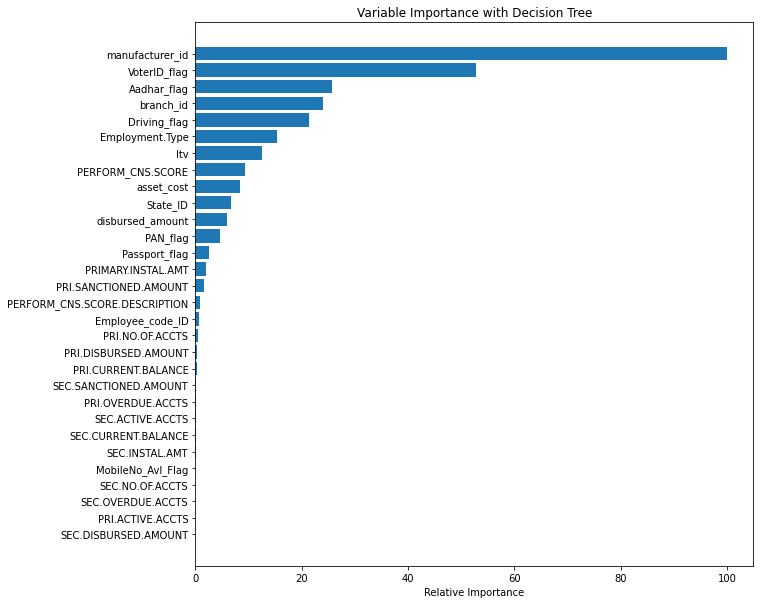

In [47]:
feature_importance = model_1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Decision Tree')
plt.show()

## Model 2: Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Build standard random forest classifier model with 100 estimators
rf = RandomForestClassifier(n_estimators = 100, random_state=1234)
model_2 = rf.fit(X_train_stand, y_train)
y_pred = model_2.predict(X_test_stand)
y_pred_prob = model_2.predict_proba(X_test_stand)
lr_probs = y_pred_prob[:1]

# obtain the accuracy, f1 and confustion matrrix
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# print results
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Random Forest: Accuracy=0.839
Random Forest: f1-score=0.838
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     36561
           1       0.91      0.75      0.82     36457

    accuracy                           0.84     73018
   macro avg       0.85      0.84      0.84     73018
weighted avg       0.85      0.84      0.84     73018



In [ ]:
# param_grid = {
#     'bootstrap':[True],
#     'max_depth':[80,90,100,110],
#     'max_features':[2,3],
#     'min_samples_leaf':[3,4,5],
#     'min_samples_split':[8,10,12],
#     'n_estimators':[100,200,300,400]
# }

# rf = RandomForestClassifier()

# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs=-1,verbose=2)

In [ ]:
# grid_search.fit(X_train_stand, y_train)
# print(grid_search.best_params_)

Print out the important features.

30


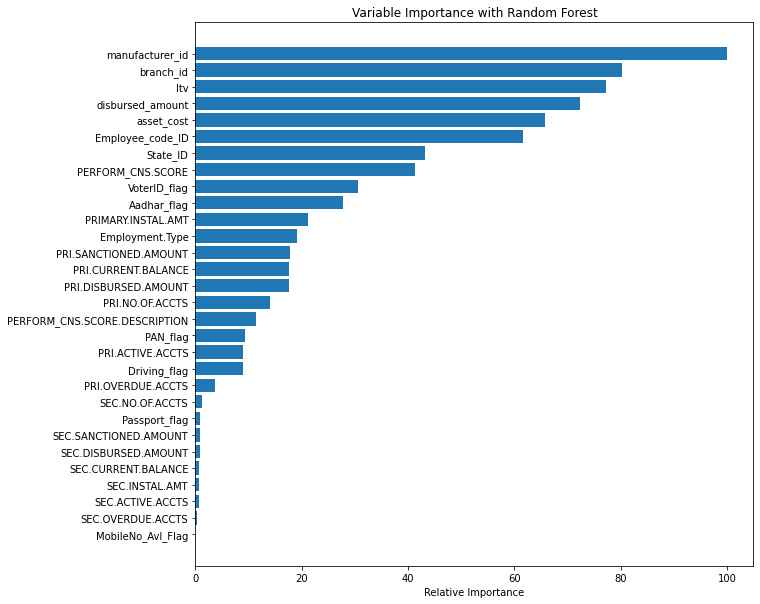

In [50]:
# print out importance of each feature

feature_importance = model_2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Random Forest')
plt.show()

## Model 3: Gradient Boosting

In [51]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

In [52]:
# Instantiate and build gradient boosting decision tree with 100 estimators and learning rate of 1
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 random_state=0).fit(X_train, y_train)
model_3 = gb.fit(X_train_stand, y_train)
y_pred = model_3.predict(X_test_stand)

# obtain accuracy, f-1 score and confusion matrix
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Gradient Boost: Accuracy=%.3f' % (ac))
print('Gradient Boost: f1-score=%.3f' % f1)
print(sklearn.metrics.classification_report(y_test, y_pred))

Gradient Boost: Accuracy=0.820
Gradient Boost: f1-score=0.818
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     36561
           1       0.91      0.71      0.80     36457

    accuracy                           0.82     73018
   macro avg       0.83      0.82      0.82     73018
weighted avg       0.83      0.82      0.82     73018



30


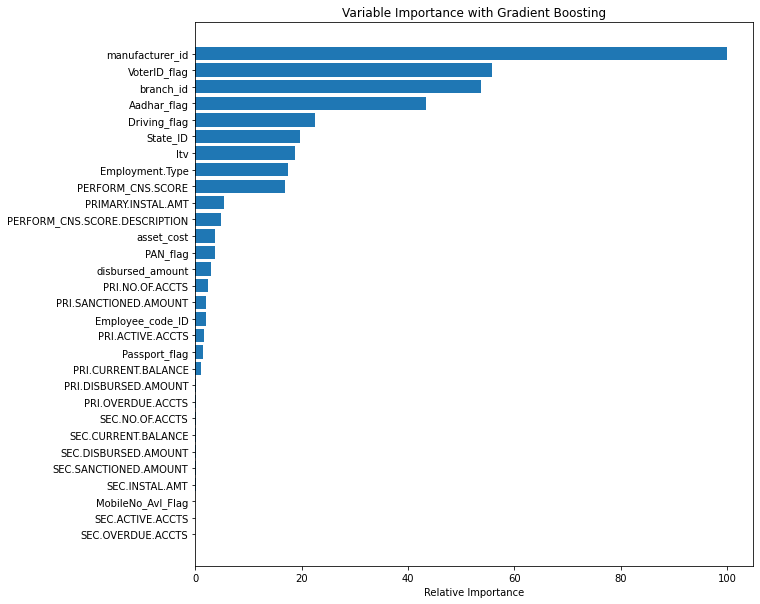

In [53]:
# print out importance of each feature

feature_importance = model_3.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Gradient Boosting')
plt.show()

Based off the accuracy score, model_2 (Random Forest) appears to have the highest score. It also has the highest precision and recall scores in the confusion matrix for the value of 1 (defaulters). In all three models, manufacturer is the most important feature for the model. 